In [39]:
library(tidyverse)
library(tidymodels)
library(dplyr)
library(ggplot2)
library(repr)
library(RColorBrewer)

options(repr.matrix.max.rows = 6)
set.seed(123)

# Introduction

Understanding player behavior is essential for improving engagement and retention in online gaming. Analyzing player characteristics and activities allows game developers to identify trends that can inform targeted recruitment efforts, subscription models, and gameplay improvements. In this study we are using players.csv, a dataset that contains various player info including experience, subscription status, hashed email identification, hours played, player names, player genders and player ages. Using this dataset, we relate age to the total played hours to determine which age range contributes the most data, helping optimize recruitment and engagement strategies.


## Players.csv

**Number Of Rows:** 196 (each row represent a unique player)

**Variables/Columns:** 7

This dataset contains information on individual players

**Variables And Their Issues:**
- **experience (character):** Holds the players experience level (beginner, amateur, regular, pro, veteran). This variable should be mutated to a factor type, as there is a set amount of categorial options
- **subscribe (logical):** Represents whether the player has an active subscription by “TRUE” or “FALSE”. It must be converted to a factor to use for categorical analysis.
- **hashedEmail (character):**  It holds the hashed value of the user’s email to link the users playing session to themselves. A possible issue is its readability in visualizations. 
- **played_hours (double):** Total hours the player has played
- **name (character):** Holds the players display name, in-game.
- **gender (character):** Describes gender of each player. A potential issue is players who have selected prefer not to say
- **age (double):** The players age in years, continuous variable. An issue is N/A missing values.


**Broad Question:** What characteristics should we target in recruiting players to obtain the largest amount of data? 

**Specific Question:** Can we predict the approximate amount of time spent playing the game given the players age in years?
By analyzing this data, we can observe what age range contributes the most playing hours. This way, we can recruit participants in the age range with the largest amount of data in-game. 


In [56]:
player_data <- read_csv("players.csv")
player_data

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


# Exploratory Data Analyses and Visualization

First, mutate the data so that both age and played hours are numeric, then filter out N/A values as well as any members who did not contribute any played hours. Then we can select columns age and played hours. This way, the dataset is modified to show only the values of interest


In [21]:
players <- player_data|>
    mutate(Age = as.numeric(Age), played_hours = as.numeric(played_hours)) |>
    filter(!is.na(Age), !is.na(played_hours), played_hours != 0) |>
    select(Age,played_hours)
players

Age,played_hours
<dbl>,<dbl>
9,30.3
17,3.8
21,0.7
⋮,⋮
44,0.1
22,0.3
17,2.3


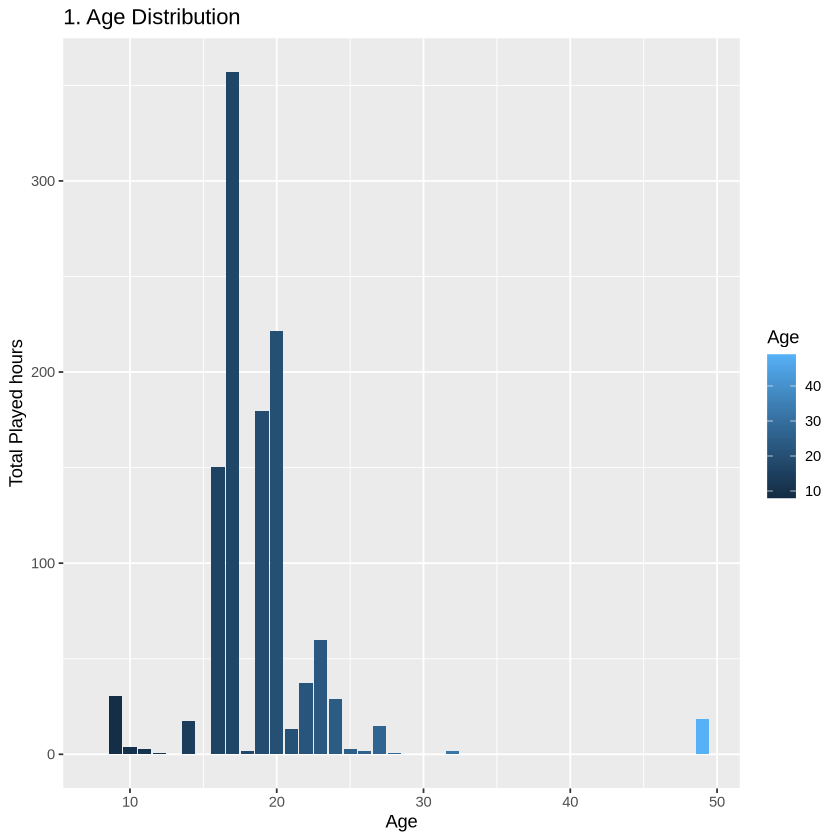

In [55]:
age_dist <- players |> ggplot(aes(x = Age, y = played_hours, fill = Age)) +
    geom_bar(stat = "identity") +
    labs(title = "1. Age vs. Total Played Hours",
       x = "Age (Years)",
       y = "Total Playtime (Hours)",
        fill = "Age")
    
age_dist

# Methods and Plan

For predicting total playing time vs age, we plan to use knn-regression. We think this is the best option because we are predicting a numerical value (playing time), which means classification methods are not needed. The ages who contribute the most playing time will be in a defined range, meaning we will not have to predict points outside of the given data so linear regression is not needed. Knn-regression will also capture trends that are unpredictable by different models like linear regression.

A weakness of the model is that it does not predict data well outside of the range of classifiers, but as mentioned we will not need to. Knn-regression is also sensitive to predictors that are not related, but our model will be unaffected as the only predictor we are using is age.

To select our best model, we will split the data into test data and training data. Using the training data, we will cross-validate to find the best k value using root mean square prediction error (RMSPE). This method also makes sure that the model doesn’t overfit or underfit the data. 

**Data Process:**

- Predict session duration with the variables age and played_hours scaled
- Split the data (70% training, 30% testing)
- Use 5 fold cross-validation to test different k values and find the lowest RMSPE 
- Test our data on the testing split
- Graph our findings

In [30]:
set.seed(123)
players_split <- initial_split(players, prop = .75, strata = Age)
players_training <- training(players_split)
players_testing <- testing(players_split)

# Training
players_recipe <- recipe(played_hours ~ Age, data = players_training) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())
players_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
          set_engine("kknn") |>
          set_mode("regression")

gridvals <- tibble(neighbors = seq(1, 40))

players_vfold <- vfold_cv(players_training, v = 5, strata = played_hours)

players_workflow <- workflow() |>
  add_recipe(players_recipe) |>
  add_model(players_spec) |>
  tune_grid(players_vfold, grid = gridvals) |>
  collect_metrics() |>
  filter(.metric == "rmse") |>
  filter(mean == min(mean))

best_k <- players_workflow |>
              pull(neighbors)
best_k

[1] 13

In [31]:
set.seed(123)
#testing
players_spec <- nearest_neighbor(weight_func = "rectangular",
                              neighbors = best_k) |>
  set_engine("kknn") |>
  set_mode("regression")

knn_mult_fit <- workflow() |>
  add_recipe(players_recipe) |>
  add_model(players_spec) |>
  fit(data = players_training)

knn_mult_preds <- knn_mult_fit |>
  predict(players_testing) |>
  bind_cols(players_testing)

knn_mult_mets <- metrics(knn_mult_preds, truth = played_hours, estimate = .pred) |>
                     filter(.metric == 'rmse')

knn_mult_mets

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,49.60902


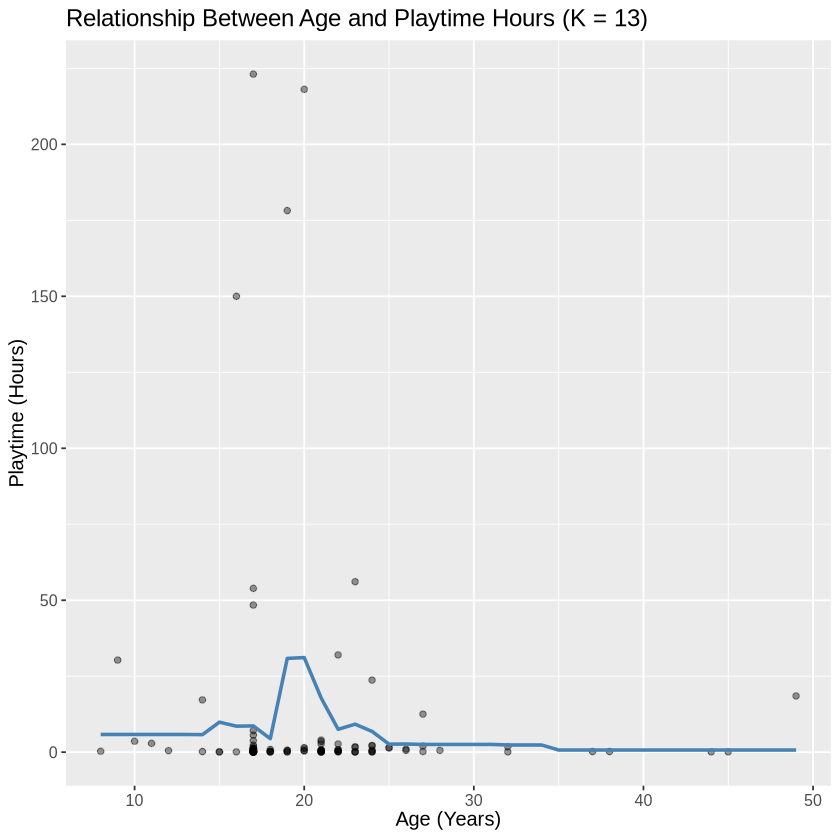

In [57]:
set.seed(123)
# graphing
age_prediction_grid <- tibble(
    Age = seq(
        from = players |> select(Age) |> min(),
        to = players |> select(Age) |> max(),
        by = 1
    )
)

players_preds <- knn_mult_fit |>
  predict(age_prediction_grid) |>
  bind_cols(age_prediction_grid)


plot_final <- ggplot(players, aes(x = Age, y = played_hours)) +
    geom_point(alpha = 0.4) +
    geom_line(data = players_preds, #players_preds
            mapping = aes(x = Age, y = .pred),
            color = "steelblue",
            linewidth = 1) +
    labs(x = "Age (Years)", y = "Playtime (Hours)") +
    ggtitle(paste0("Relationship Between Age and Playtime Hours (K = ", best_k, ")")) +
    theme(text = element_text(size = 12))

plot_final

# Discussion
**What We Found**

By applying k-nearest regression, we modeled the relationship between age and total played hours. After that, we tuned the model through 5-fold cross-validation, identifying the optimal value of k to minimize the error (RMSE). Our final model reveals a clear trend between age and playtime, indicating that those in their teens to early 20s tend to spend more time than others. 

We found that ages between 15-25 had the highest average gameplay time. This suggests that this demographic is the most engaged or has the most time available to play, which confirms that age has a noticeable effect on playtime and supports the idea of targeting specific age groups for better player engagement. This was expected, as younger players often have more free time and tend to be more engaged with online games.

**Our Findings Impacts**

These findings can help game developers and researchers target recruitment strategies more effectively. By focusing on recruiting the age group from 15-25, it can help yield more gameplay data per person, improving data efficiency. Additionally, understanding who contributes the most data could influence content development, marketing strategies, and in-game reward systems tailored to that age group.

**Future Questions**

This analysis opens the door to several future questions:
Do certain experience levels (e.g., "pro" or "veteran") correlate with age or played hours?
Are there temporal patterns in session times that vary with age (e.g., evening vs. daytime play)?
What other demographic or behaviour variables could help refine player engagement models?
